In [ ]:
import pandas as pd
import nannyml as nml
reference_df, analysis_df, analysis_targets_df = nml.datasets.load_modified_california_housing_dataset()
reference_df.head(3)

,id,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,timestamp,clf_target,y_pred_proba,y_pred
0,0,9.8413,32.0,7.170040,1.014845,4353.0,2.937247,34.22,-118.19,2020-10-01 00:00:00,1,0.99,1
1,1,8.3695,37.0,7.458746,1.062706,941.0,3.105611,34.22,-118.21,2020-10-01 01:00:00,1,1.00,1
2,2,8.7200,44.0,6.163180,1.046025,668.0,2.794979,34.20,-118.18,2020-10-01 02:00:00,1,1.00,1


In [ ]:
print(reference_df.head(3).to_markdown(tablefmt="grid"))

+----+------+----------+------------+------------+-------------+--------------+------------+------------+-------------+---------------------+--------------+----------------+----------+
|    |   id |   MedInc |   HouseAge |   AveRooms |   AveBedrms |   Population |   AveOccup |   Latitude |   Longitude | timestamp           |   clf_target |   y_pred_proba |   y_pred |
+====+======+==========+============+============+=============+==============+============+============+=============+=====================+==============+================+==========+
|  0 |    0 |   9.8413 |         32 |    7.17004 |     1.01484 |         4353 |    2.93725 |      34.22 |     -118.19 | 2020-10-01 00:00:00 |            1 |           0.99 |        1 |
+----+------+----------+------------+------------+-------------+--------------+------------+------------+-------------+---------------------+--------------+----------------+----------+
|  1 |    1 |   8.3695 |         37 |    7.45875 |     1.06271 |          9

In [ ]:
# fit performance estimator and estimate for combined reference and analysis
cbpe = nml.CBPE(
    y_pred='y_pred',
    y_pred_proba='y_pred_proba',
    y_true='clf_target',
    timestamp_column_name='timestamp',
    problem_type='classification_binary',
    chunk_period='M',
    metrics=['roc_auc'])
cbpe.fit(reference_data=reference_df)
est_perf = cbpe.estimate(analysis_df)

In [ ]:
est_perf_data = est_perf.to_df()
print(est_perf.data[('chunk', 'end_index')] - est_perf.data[('chunk', 'start_index')])

0     743
1     719
2     743
3     743
4     671
5     743
6     719
7     743
8     719
9     743
10    743
11    719
12    743
13    719
14    743
15    743
16    671
17    743
18    719
19    215
dtype: int64


In [ ]:
est_perf.data = est_perf.data[:-1].copy()
est_perf.data.tail(2)

chunk                                               \
        key chunk_index start_index end_index start_date   
17  2022-03           9        6552      7295 2022-03-01   
18  2022-04          10        7296      8015 2022-04-01   

                                             roc_auc                          \
                        end_date    period     value sampling_error realized   
17 2022-03-31 23:59:59.999999999  analysis  0.829077       0.007781      NaN   
18 2022-04-30 23:59:59.999999999  analysis  0.910661       0.007910      NaN   

                                                                        \
   upper_confidence_boundary lower_confidence_boundary upper_threshold   
17                   0.85242                  0.805734               1   
18                   0.93439                  0.886932               1   

                           
   lower_threshold  alert  
17        0.708336  False  
18        0.708336  False

In [ ]:
from docs.utils import print_multi_index_markdown
print_multi_index_markdown(est_perf.data.tail(2))

+----+-----------+-----------------+-----------------+---------------+---------------------+-------------------------------+------------+-------------+--------------------+--------------+-------------------------------+-------------------------------+---------------------+---------------------+-----------+
|    | | chunk   |                 |                 |               |                     |                               |            | | roc_auc   |                    |              |                               |                               |                     |                     |           |
|    | | key     | | chunk_index   | | start_index   | | end_index   | | start_date        | | end_date                    | | period   | | value     | | sampling_error   | | realized   | | upper_confidence_boundary   | | lower_confidence_boundary   | | upper_threshold   | | lower_threshold   | | alert   |
+====+===========+=================+=================+===============+======

In [ ]:
fig = est_perf.filter(metrics=['roc_auc'], period='analysis').plot()
fig.show()

In [ ]:
fig.write_image(file=f"../_static/example_california_performance.svg")

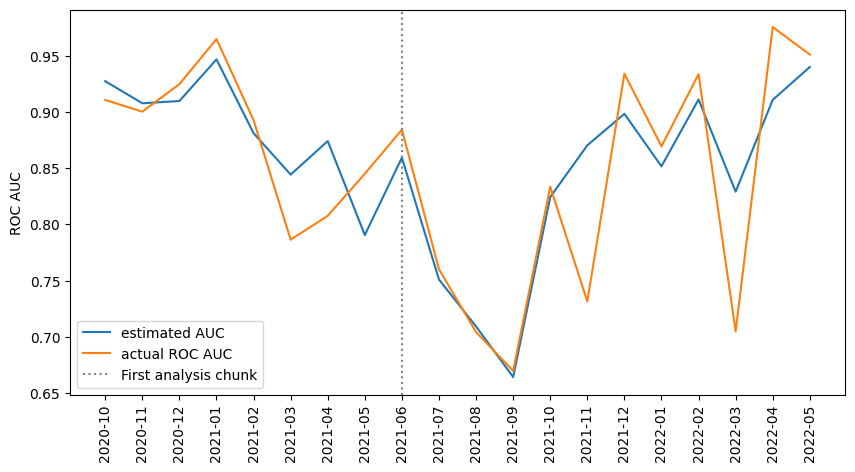

In [ ]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
# add ground truth to analysis
analysis_full = pd.merge(analysis_df, analysis_targets_df, left_index=True, right_index=True)
df_all = pd.concat([reference_df, analysis_full]).reset_index(drop=True)
df_all['timestamp'] = pd.to_datetime(df_all['timestamp'])
# calculate actual ROC AUC
target_col = cbpe.y_true
pred_score_col = 'y_pred_proba'
actual_performance = []
for idx in est_perf_data.index:
    start_date, end_date = est_perf_data.loc[idx, ('chunk', 'start_date')], est_perf_data.loc[idx, ('chunk', 'end_date')]
    sub = df_all[df_all['timestamp'].between(start_date, end_date)]
    actual_perf = roc_auc_score(sub[target_col], sub[pred_score_col])
    est_perf_data.loc[idx, ('roc_auc', 'realized')] = actual_perf
# plot
first_analysis = est_perf_data[('chunk', 'key')].values[8]
plt.figure(figsize=(10,5))
plt.plot(est_perf_data[('chunk', 'key')], est_perf_data[('roc_auc', 'value')], label='estimated AUC')
plt.plot(est_perf_data[('chunk', 'key')], est_perf_data[('roc_auc', 'realized')], label='actual ROC AUC')
plt.xticks(rotation=90)
plt.axvline(x=first_analysis, label='First analysis chunk', linestyle=':', color='grey')
plt.ylabel('ROC AUC')
plt.legend()
plt.show()

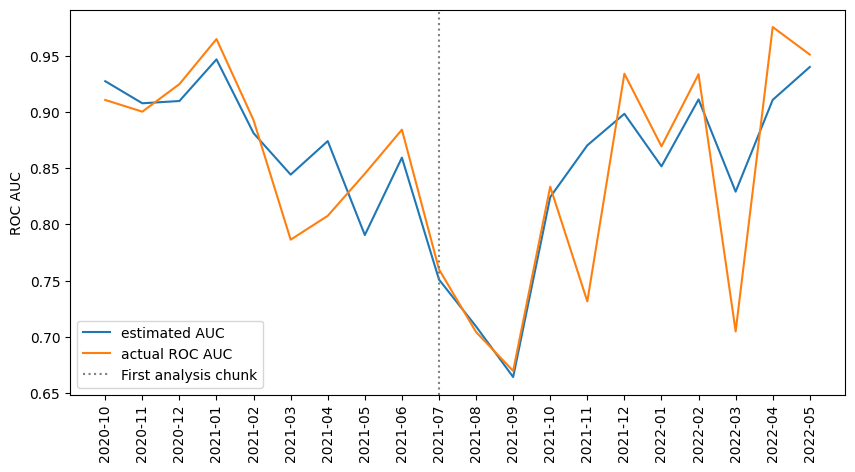

In [ ]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
# add ground truth to analysis
analysis_full = pd.merge(analysis_df, analysis_targets_df, left_index=True, right_index=True)
df_all = pd.concat([reference_df, analysis_full]).reset_index(drop=True)
df_all['timestamp'] = pd.to_datetime(df_all['timestamp'])
# calculate actual ROC AUC
target_col = cbpe.y_true
pred_score_col = 'y_pred_proba'
actual_performance = []
for idx in est_perf_data.index:
    start_date, end_date = est_perf_data.loc[idx, ('chunk', 'start_date')], est_perf_data.loc[idx, ('chunk', 'end_date')]
    sub = df_all[df_all['timestamp'].between(start_date, end_date)]
    actual_perf = roc_auc_score(sub[target_col], sub[pred_score_col])
    est_perf_data.loc[idx, ('roc_auc', 'realized')] = actual_perf
# plot
first_analysis = est_perf_data[('chunk', 'key')].values[9]
plt.figure(figsize=(10,5))
plt.plot(est_perf_data[('chunk', 'key')], est_perf_data[('roc_auc', 'value')], label='estimated AUC')
plt.plot(est_perf_data[('chunk', 'key')], est_perf_data[('roc_auc', 'realized')], label='actual ROC AUC')
plt.xticks(rotation=90)
plt.axvline(x=first_analysis, label='First analysis chunk', linestyle=':', color='grey')
plt.ylabel('ROC AUC')
plt.legend()
plt.savefig("../_static/example_california_performance_estimation_tmp.svg")

In [ ]:
feature_column_names = [
    col for col in reference_df
    if col not in ['y_pred', 'y_pred_proba', 'clf_target', 'timestamp']]

univariate_calculator = nml.UnivariateDriftCalculator(column_names=feature_column_names,
                                                      timestamp_column_name='timestamp',
                                                      chunk_period='M',
                                                      continuous_methods=['kolmogorov_smirnov'],
                                                      categorical_methods=['chi2']).fit(reference_data=reference_df)
univariate_results = univariate_calculator.calculate(analysis_df)
nml.AlertCountRanker().rank(univariate_results)

,number_of_alerts,column_name,rank
0,3,Longitude,1
1,1,Latitude,2
2,0,id,3
3,0,Population,4
4,0,MedInc,5
5,0,HouseAge,6
6,0,AveRooms,7
7,0,AveOccup,8
8,0,AveBedrms,9


In [ ]:
ranked = nml.AlertCountRanker().rank(univariate_results)
print(ranked.to_markdown(tablefmt="grid"))

+----+--------------------+---------------+--------+
|    |   number_of_alerts | column_name   |   rank |
+====+====================+===============+========+
|  0 |                  3 | Longitude     |      1 |
+----+--------------------+---------------+--------+
|  1 |                  1 | Latitude      |      2 |
+----+--------------------+---------------+--------+
|  2 |                  0 | id            |      3 |
+----+--------------------+---------------+--------+
|  3 |                  0 | Population    |      4 |
+----+--------------------+---------------+--------+
|  4 |                  0 | MedInc        |      5 |
+----+--------------------+---------------+--------+
|  5 |                  0 | HouseAge      |      6 |
+----+--------------------+---------------+--------+
|  6 |                  0 | AveRooms      |      7 |
+----+--------------------+---------------+--------+
|  7 |                  0 | AveOccup      |      8 |
+----+--------------------+---------------+---

In [ ]:
# get columns with d statistics only
# # # print(result.data.loc[:, (non_chunk, slice(None), 'alert')])
univariate_results.to_df().loc[:, (slice(None), 'kolmogorov_smirnov', 'value')].mean().sort_values(ascending=False)

id          kolmogorov_smirnov  value    0.874280
Longitude   kolmogorov_smirnov  value    0.712709
Latitude    kolmogorov_smirnov  value    0.672904
HouseAge    kolmogorov_smirnov  value    0.201638
MedInc      kolmogorov_smirnov  value    0.154952
AveOccup    kolmogorov_smirnov  value    0.143890
AveRooms    kolmogorov_smirnov  value    0.129277
AveBedrms   kolmogorov_smirnov  value    0.089140
Population  kolmogorov_smirnov  value    0.073562
dtype: float64

In [ ]:
print(univariate_results.to_df().loc[:, (slice(None), 'kolmogorov_smirnov', 'value')].mean().sort_values(ascending=False).to_markdown(tablefmt="grid"))

+-----------------------------------------------+-----------+
|                                               |         0 |
+===============================================+===========+
| ('id', 'kolmogorov_smirnov', 'value')         | 0.87428   |
+-----------------------------------------------+-----------+
| ('Longitude', 'kolmogorov_smirnov', 'value')  | 0.712709  |
+-----------------------------------------------+-----------+
| ('Latitude', 'kolmogorov_smirnov', 'value')   | 0.672904  |
+-----------------------------------------------+-----------+
| ('HouseAge', 'kolmogorov_smirnov', 'value')   | 0.201638  |
+-----------------------------------------------+-----------+
| ('MedInc', 'kolmogorov_smirnov', 'value')     | 0.154952  |
+-----------------------------------------------+-----------+
| ('AveOccup', 'kolmogorov_smirnov', 'value')   | 0.14389   |
+-----------------------------------------------+-----------+
| ('AveRooms', 'kolmogorov_smirnov', 'value')   | 0.129277  |
+-------

In [ ]:
fig = univariate_results.filter(
    column_names=['Longitude', 'Latitude'],
    period='analysis',
    methods=['kolmogorov_smirnov']
).plot(kind='distribution', number_of_columns=1)
fig.show()

In [ ]:
fig = univariate_results.filter(
    column_names=['Longitude', 'Latitude'],
    period='analysis',
    methods=['kolmogorov_smirnov']
).plot(kind='distribution', number_of_columns=1)
fig.write_image(f"../_static/example_california_performance_distribution.svg")

Text(0, 0.5, 'Longitude')

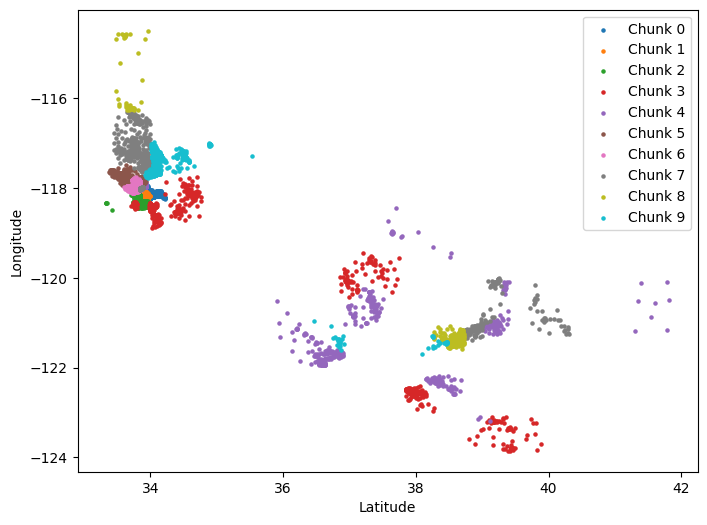

In [ ]:
analysis_res = est_perf.data
plt.figure(figsize=(8,6))
for idx in analysis_res.index[:10]:
    start_date, end_date = analysis_res.loc[idx, ('chunk', 'start_date')], analysis_res.loc[idx, ('chunk', 'end_date')]
    sub = df_all[df_all['timestamp'].between(start_date, end_date)]
    plt.scatter(sub['Latitude'], sub['Longitude'], s=5, label="Chunk {}".format(str(idx)))

plt.legend()
plt.xlabel('Latitude')
plt.ylabel('Longitude')

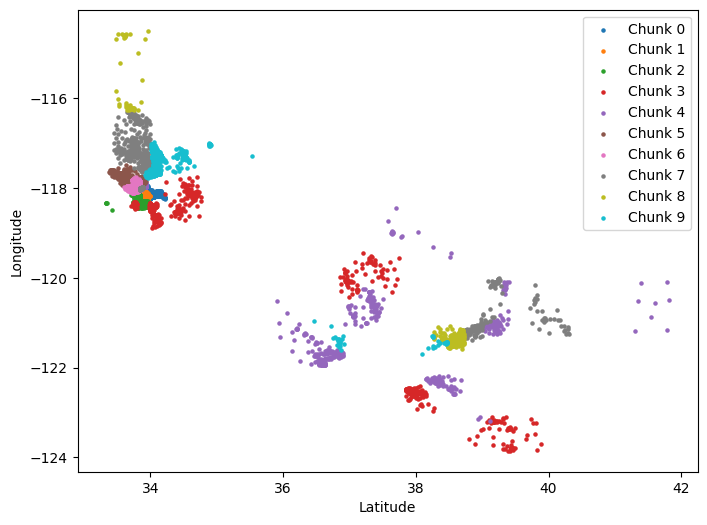

In [ ]:
analysis_res = est_perf.data
plt.figure(figsize=(8,6))
for idx in analysis_res.index[:10]:
    start_date, end_date = analysis_res.loc[idx, ('chunk', 'start_date')], analysis_res.loc[idx, ('chunk', 'end_date')]
    sub = df_all[df_all['timestamp'].between(start_date, end_date)]
    plt.scatter(sub['Latitude'], sub['Longitude'], s=5, label="Chunk {}".format(str(idx)))

plt.legend()
plt.xlabel('Latitude')
plt.ylabel('Longitude')

plt.savefig("../_static/example_california_latitude_longitude_scatter.svg")
